In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('/content/train.csv')
train

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [3]:
df = pd.DataFrame({'label':train.label, 'tweet':train.tweet})

In [4]:
def punc(df):
    df['tweet'] = df['tweet'].str.replace('[#@()]','')
    print(df)

punc(df)

       label                                              tweet
0          0   user when a father is dysfunctional and is so...
1          0  user user thanks for lyft credit i can't use c...
2          0                                bihday your majesty
3          0  model   i love u take with u all the time in u...
4          0              factsguide: society now    motivation
...      ...                                                ...
31957      0  ate user isz that youuu?ðððððð...
31958      0    to see nina turner on the airwaves trying to...
31959      0  listening to sad songs on a monday morning otw...
31960      1  user sikh temple vandalised in in calgary, wso...
31961      0                    thank you user for you follow  

[31962 rows x 2 columns]


In [5]:
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [6]:
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os

In [7]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df, valid_df = df_test, path = "")

In [8]:
data_lm.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (19177 items)
x: LMTextList
xxbos feel so proud of everything i have achieved in xxunk,xxbos best homeopathic remedies for anxiety - altwaystoheal healing peace ! !,xxbos [ xxunk ] [ xxunk ] murdered : soul suspect user user xxunk xxunk xxunk,xxbos life is better when you 're laughing xxunk,xxbos daily express : xxunk sour xxunk xxunk 's xxunk society yet again : bitter ..
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (12785 items)
x: LMTextList
xxbos user i m crying i m so xxunk,xxbos gon na give some white people a taste of ramadan today ð,xxbos user oh . my . god,xxbos beachbody bull up : you will dominate your bull and you will direct it whatever you want it to do . when yo,xxbos have n't been this happy in years ! lovinglife xxunk xxunk ¦
y: LMLabelList
,,,,
Path: .;

Test: None>

In [9]:
data_lm.train_ds.vocab.itos[:30]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'user',
 '!',
 '.',
 'the',
 'to',
 'i',
 'a',
 ',',
 '¦',
 'you',
 'and',
 'in',
 'for',
 'is',
 'of',
 'my',
 'it',
 '&',
 "'s",
 ':',
 'love']

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 6.31E-02


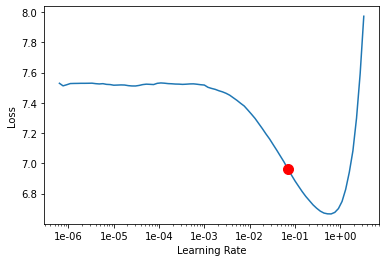

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [13]:
#fitting the data
learn.fit_one_cycle(2, 5e-2)
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,5.516006,4.763690,0.250114,00:15
1,4.660367,4.578280,0.268774,00:15


In [14]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.186577,4.479672,0.279611,00:19
1,3.892612,4.352221,0.299905,00:19
2,3.088648,4.500777,0.300494,00:20


In [15]:
learn.freeze_to(-1)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 3.63E-04


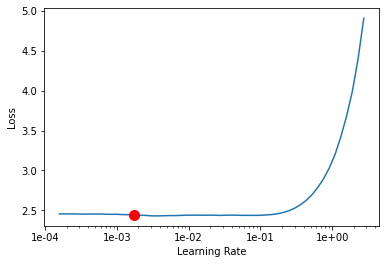

In [16]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [17]:
learn.fit_one_cycle(3, slice(2e-2/(2.6**4), 2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.570567,4.640058,0.298300,00:16
1,2.451011,4.712243,0.299710,00:16
2,2.159781,4.734273,0.301244,00:17


In [18]:
learn.freeze_to(-2)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 7.59E-04


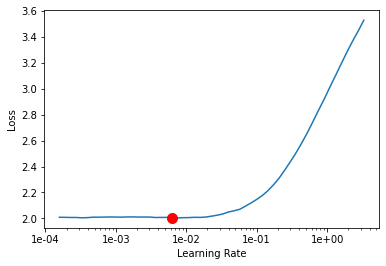

In [19]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [20]:
learn.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.014399,4.796779,0.301069,00:17
1,1.968538,4.840931,0.300480,00:17
2,1.920317,4.850333,0.300575,00:17


In [21]:
learn.save_encoder('my_encoder')

In [22]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

In [23]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])
learn.load_encoder('my_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19177 items)
x: TextList
xxbos feel so proud of everything i have achieved in xxunk,xxbos best homeopathic remedies for anxiety - altwaystoheal healing peace ! !,xxbos [ xxunk ] [ xxunk ] murdered : soul suspect user user xxunk xxunk xxunk,xxbos life is better when you 're laughing xxunk,xxbos daily express : xxunk sour xxunk xxunk 's xxunk society yet again : bitter ..
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (12785 items)
x: TextList
xxbos user i m crying i m so xxunk,xxbos gon na give some white people a taste of ramadan today ð,xxbos user oh . my . god,xxbos beachbody bull up : you will dominate your bull and you will direct it whatever you want it to do . when yo,xxbos have n't been this happy in years ! lovinglife xxunk xxunk ¦
y: CategoryList
0,0,0,0,0
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(11352, 400, padding_idx=1)
      (encoder

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 3.63E-02


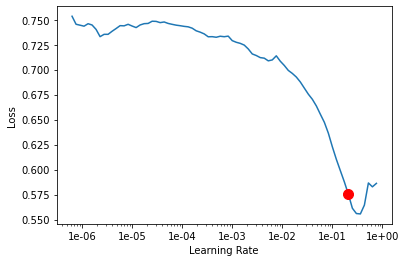

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
learn.fit_one_cycle(3, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.193541,0.165025,0.939304,0.388013,00:13
1,0.147277,0.147346,0.944936,0.416252,00:13
2,0.163703,0.143685,0.947047,0.444627,00:12


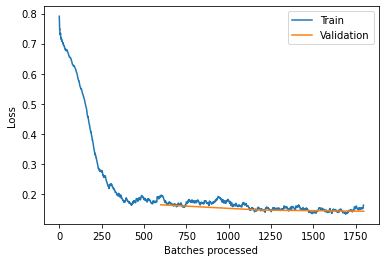

In [26]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 9.12E-08


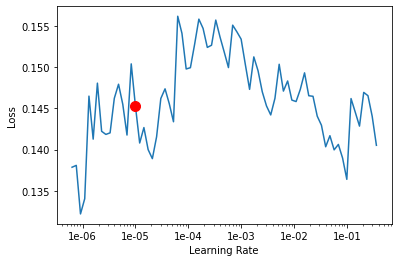

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
learn.freeze_to(-2) # unfreeze last 2 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.147042,0.135484,0.950020,0.511841,00:14
1,0.113717,0.128618,0.953774,0.559284,00:15


In [29]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5.3e-3/(2.6**4),5.31e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.132333,0.120526,0.955573,0.586608,00:23
1,0.074898,0.115604,0.960657,0.649477,00:22


In [30]:
learn.freeze_to(-4) # unfreeze last 4 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.freeze_to(-5) # unfreeze last 5 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

# Unfreezing all the layers and training
learn.unfreeze() # unfreze all
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.082936,0.118668,0.960188,0.656777,00:27
1,0.049910,0.122839,0.961205,0.680824,00:27


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.060852,0.149555,0.960031,0.627279,00:28
1,0.023904,0.149308,0.963160,0.697106,00:29


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.025362,0.164461,0.963551,0.698187,00:29
1,0.015756,0.186241,0.964333,0.693136,00:29
2,0.011746,0.171708,0.963942,0.702004,00:29


In [31]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)


In [32]:
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,11781,354
1,107,543


In [33]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
cm=confusion_matrix(predictions,targets)
print(cm)
score = accuracy_score( predictions, targets)
print(score)

[[11781   354]
 [  107   543]]
0.96394211967149
